<a href="https://colab.research.google.com/github/Provan02/ImageRecognition/blob/main/Copy_of_Untitled0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import itertools
import os
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
print("TF version:", tf.__version__)
print("Hub version", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")



TF version: 2.12.0
Hub version 0.13.0
GPU is available


In [ ]:
from google.colab import drive
drive.mount ('/content/drive')


Mounted at /content/drive


In [ ]:
model_name = "resnet_v2_50"
model_handle = "https://tfhub.dev/google/imagenet/resnet v2 50/feature-vector/5"
pixels = (224, 244)
print(f"Selected model: {model_name} : {model_handle}")
IMAGE_SIZE = (pixels, pixels)
print(f"Input sie {IMAGE_SIZE}")
BATCH_SIZE = 16#@param {type: "integer"}

Selected model: resnet_v2_50 : https://tfhub.dev/google/imagenet/resnet v2 50/feature-vector/5
Input sie ((224, 244), (224, 244))


In [ ]:
data_dir = "/content/drive/My Drive/AI Data/train"
def build_dataset(subset):
  return tf.keras.preprocessing.image_dataset_from_directory(data_dir,validation_split=.10,subset=subset,label_mode="categorical",seed=123,image_size=(224,224),batch_size=1)
train_ds = build_dataset("training")
class_names = tuple(train_ds.class_names)
train_size = train_ds.cardinality().numpy()
train_ds = train_ds.unbatch().batch(BATCH_SIZE)
train_ds = train_ds.repeat()
normalization_layer = tf.keras.layers.Rescaling(1. / 255)
preprocessing_model = tf.keras.Sequential([normalization_layer])
do_data_augmentation = True #@param {type:"boolean"}
if do_data_augmentation:
  preprocessing_model.add(tf.keras.layers.RandomRotation(40))
  preprocessing_model.add(tf.keras.layers.RandomTranslation(0, 0.2))
  preprocessing_model.add(tf.keras.layers.RandomTranslation(0.2, 0))
  # Like the old tf.keras.preprocessing.image.ImageDataGenerator(),
  # image sizes are fixed when reading, and then a random zoom is applied.
  # RandomCrop with a batch size of 1 and rebatch later.
  preprocessing_model.add(tf.keras.layers.RandomZoom(0.2, 0.2))
  preprocessing_model.add(tf.keras.layers.RandomFlip(mode="horizontal"))
train_ds = train_ds.map(lambda images, labels:(preprocessing_model(images), labels))
val_ds = build_dataset("validation")
valid_size = val_ds.cardinality().numpy()
val_ds = val_ds.unbatch().batch(BATCH_SIZE)
val_ds = val_ds.map(lambda images, labels:(normalization_layer(images), labels))


Found 3115 files belonging to 36 classes.
Using 2804 files for training.
Found 3115 files belonging to 36 classes.
Using 311 files for validation.


In [ ]:
do_fine_tuning = True
print("Building model with", model_handle)
model = tf.keras.Sequential([
    # Explicitly define the input shape so the model can be properly
    # loaded by the TFLiteConverter
    tf.keras.layers.InputLayer(input_shape=(224, 224) + (3,)),
    hub.KerasLayer("https://tfhub.dev/google/imagenet/resnet_v2_152/feature_vector/5"),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(len(class_names),activation='sigmoid',
    kernel_regularizer=tf.keras.regularizers.l2(0.0001))
    ])
model.build((None,)+(224, 244)+(3,))
model.summary()

Building model with https://tfhub.dev/google/imagenet/resnet v2 50/feature-vector/5
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 2048)              58331648  
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 36)                73764     
                                                                 
Total params: 58,405,412
Trainable params: 73,764
Non-trainable params: 58,331,648
_________________________________________________________________


In [ ]:
model_result = model.compile(
  optimizer=tf.keras.optimizers.SGD(learning_rate=0.005, momentum=0.9),
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.1),
  metrics=['accuracy'])

steps_per_epoch = train_size // BATCH_SIZE

validation_steps = valid_size // BATCH_SIZE

hist = model.fit(

train_ds,

epochs=50, steps_per_epoch=steps_per_epoch,

validation_data=val_ds,

validation_steps=validation_steps).history

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/backend.py:5561: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


175/175 [==============================] - 542s 3s/step - loss: 1.4966 - accuracy: 0.7829 - val_loss: 1.7336 - val_accuracy: 0.7566
Epoch 2/50
175/175 [==============================] - 118s 673ms/step - loss: 1.5112 - accuracy: 0.7794 - val_loss: 1.7781 - val_accuracy: 0.7401
Epoch 3/50
175/175 [==============================] - 111s 638ms/step - loss: 1.4911 - accuracy: 0.7826 - val_loss: 1.7424 - val_accuracy: 0.7632
Epoch 4/50
175/175 [==============================] - 109s 625ms/step - loss: 1.5168 - accuracy: 0.7805 - val_loss: 1.7875 - val_accuracy: 0.7467
Epoch 5/50
175/175 [==============================] - 117s 673ms/step - loss: 1.5162 - accuracy: 0.7744 - val_loss: 1.7901 - val_accuracy: 0.7500
Epoch 6/50
175/175 [==============================] - 115s 662ms/step - loss: 1.5056 - accuracy: 0.7884 - val_loss: 1.7441 - val_accuracy: 0.7434
Epoch 7/50
175/175 [==============================] - 99s 567ms/step - loss: 1.5452 - accuracy: 0.7672 - val_loss: 1.6988 - val_accuracy: 

In [ ]:
model.save ("/content/drive/My Drive/AI Data/"+model_name+".h5")


In [ ]:
# Load model if already trained
from keras.models import load_model
model = load_model("/content/drive/My Drive/AI Data/resnet_v2_50.h5",custom_objects={"KerasLayer":hub.KerasLayer})

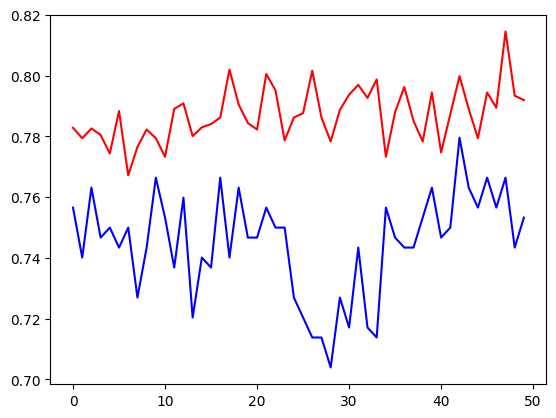

In [ ]:
plt.plot(hist['accuracy'] , color = 'red' , label = 'accuracy')
plt.plot(hist['val_accuracy'] , color = 'blue' , label = 'val_accuracy')